/tmp/ipython-input-1895903611.py:70: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text)


Tickers used: ['NVDA', 'MSFT', 'AAPL', 'GOOGL', 'GOOG', 'AMZN', 'META', 'AVGO', 'TSLA', 'BRK-B', 'JPM', 'WMT', 'V', 'ORCL', 'LLY', 'NFLX', 'MA', 'XOM', 'JNJ', 'COST', 'HD', 'ABBV', 'PG', 'BAC', 'PLTR', 'CVX', 'GE', 'KO', 'UNH', 'TMUS']


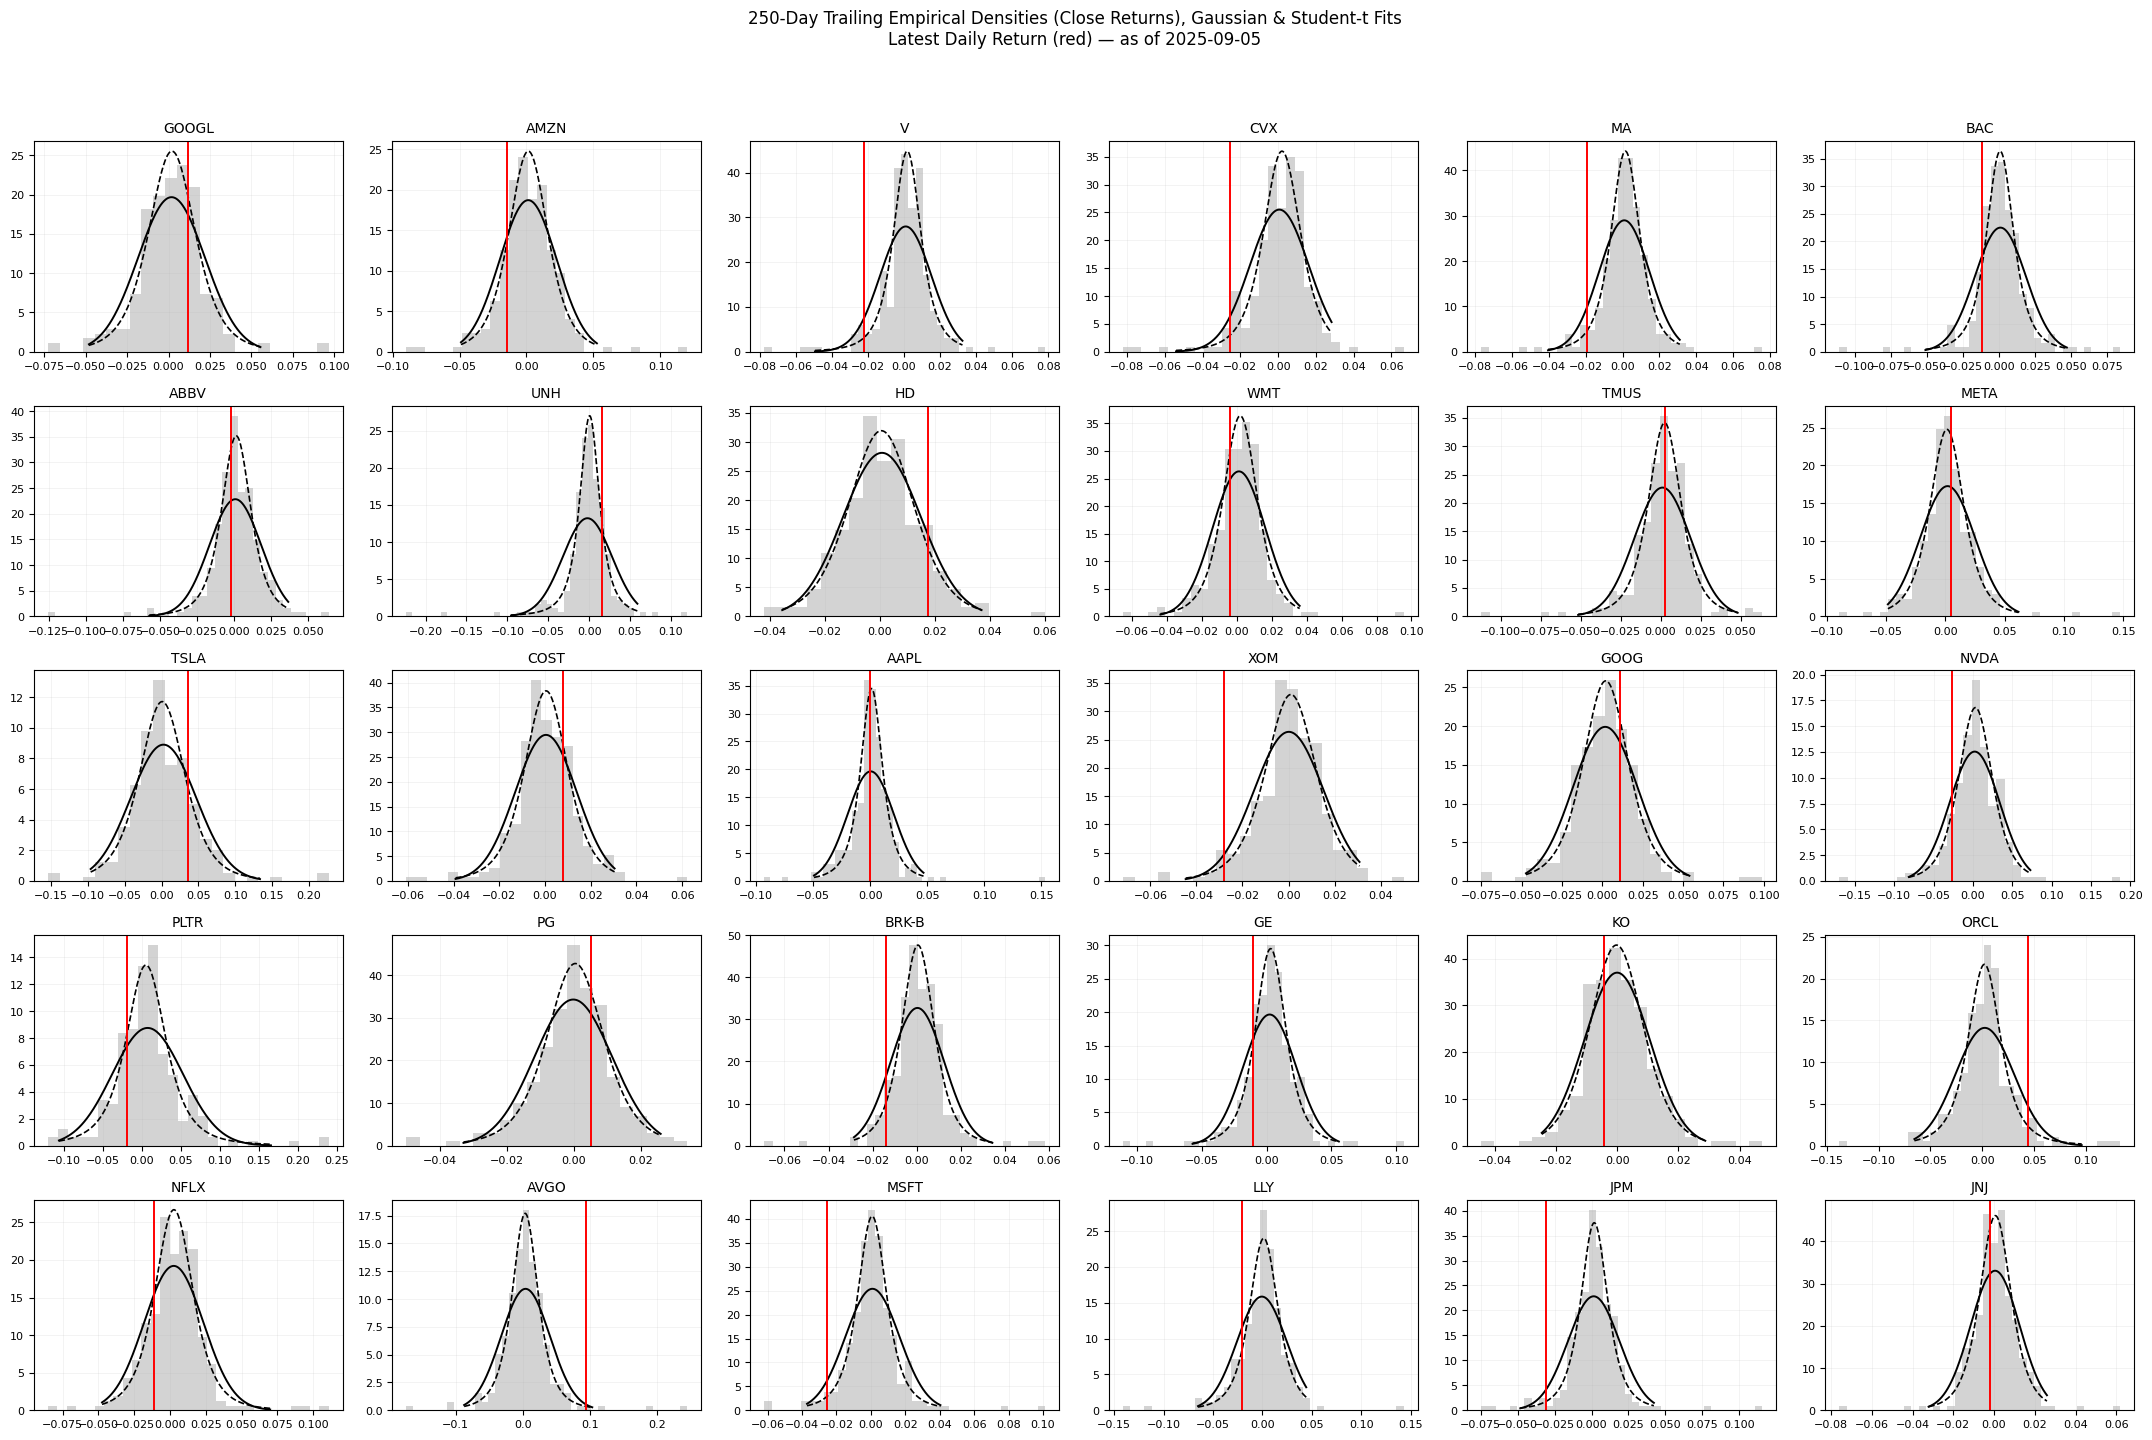

In [3]:
"""
Top-30 S&P 500 Distribution Monitor (Close-only)
------------------------------------------------
Builds a small-multiples panel for the 30 largest S&P 500 stocks by market cap.
Each subplot uses the last 250 trading days of **CLOSE** returns only:
  - Grey histogram = empirical density
  - Black solid = Normal fit
  - Black dashed = Student-t fit
  - Red vertical line = latest daily return

If Wikipedia blocks scraping (403), we use a real User-Agent and then fall back
to yfinance.tickers_sp500() or MANUAL_TICKERS.
"""

# If needed:
# !pip install yfinance scipy pandas matplotlib requests lxml --quiet

import math
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import yfinance as yf
import requests

# -------------------- CONFIG --------------------
USE_DYNAMIC_TOPN = True     # True: discover top-N by market cap today. False: use MANUAL_TICKERS.
TOP_N = 30                  # number of names to show
LOOKBACK_DAYS = 400         # download slightly more than 250 trading days
WINDOW = 250                # trailing window for fits
BINS = "fd"                 # histogram bins rule
SAVEFIG = True
OUTFILE = f"snp_top{TOP_N}_close_only_{dt.date.today()}.png"

# Optional manual list (~top 30; edit freely if you lock the universe)
MANUAL_TICKERS = [
    "NVDA","MSFT","AAPL","GOOGL","AMZN","META","LLY","BRK-B","AVGO","JPM",
    "XOM","UNH","JNJ","V","COST","TSLA","WMT","PG","MA","MRK",
    "ORCL","HD","PEP","KO","ABBV","BAC","CVX","ADBE","CRM","ACN"
]
# =======================================================


def _fix_for_yf(ticker: str) -> str:
    """Convert S&P-style tickers (e.g., BRK.B) to yfinance (BRK-B)."""
    return ticker.replace(".", "-").strip()


def get_sp500_constituents():
    """
    Return S&P 500 tickers (normalized for yfinance), with robust fallbacks:
      1) Wikipedia with a real User-Agent
      2) yfinance.tickers_sp500()
      3) MANUAL_TICKERS
    """
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
            "(KHTML, like Gecko) Chrome/124.0 Safari/537.36"
        )
    }

    # 1) Wikipedia scrape with real UA
    try:
        resp = requests.get(url, headers=headers, timeout=20)
        resp.raise_for_status()
        tables = pd.read_html(resp.text)
        spx = tables[0]
        tickers = [_fix_for_yf(t) for t in spx["Symbol"].tolist()]
        tickers = [t for t in tickers if t]
        if len(tickers) > 400:
            return tickers
    except Exception as e:
        print(f"[WARN] Wikipedia fetch failed ({e}). Trying yfinance.tickers_sp500()...")

    # 2) yfinance helper
    try:
        yf_list = getattr(yf, "tickers_sp500", None)
        if callable(yf_list):
            tickers = [_fix_for_yf(t) for t in yf_list()]
            if len(tickers) > 400:
                return tickers
    except Exception as e:
        print(f"[WARN] yfinance.tickers_sp500() failed ({e}).")

    # 3) Fallback manual
    print("[INFO] Using MANUAL_TICKERS fallback.")
    return MANUAL_TICKERS


def pick_top_by_marketcap(all_tickers, top_n=TOP_N):
    """
    Fetch market caps and return the largest `top_n` tickers.
    Keeps both GOOG/GOOGL if they both qualify (they're separate share classes).
    """
    caps = []
    for t in all_tickers:
        try:
            tk = yf.Ticker(t)
            mcap = tk.fast_info.get("market_cap")
            if mcap is None:
                mcap = tk.info.get("marketCap")
            if mcap:
                caps.append((t, int(mcap)))
        except Exception:
            continue

    if not caps:
        print("[WARN] Could not retrieve market caps; using MANUAL_TICKERS.")
        return MANUAL_TICKERS[:top_n]

    top = (pd.DataFrame(caps, columns=["ticker", "market_cap"])
             .sort_values("market_cap", ascending=False))
    return top.head(top_n)["ticker"].tolist()


def get_close_prices(tickers, lookback_days=LOOKBACK_DAYS):
    """
    Download **Close** prices only for the window.
    Handles both multi-index (ticker, field) and single-index returns from yfinance.
    """
    data = yf.download(
        tickers=tickers,
        period=f"{lookback_days}d",
        interval="1d",
        auto_adjust=True,         # ensures 'Close' is split- & dividend-adjusted
        progress=False,
        group_by="ticker",
    )

    # MultiIndex: columns like ('AAPL','Open'), ('AAPL','Close'), ...
    if isinstance(data.columns, pd.MultiIndex):
        if "Close" in data.columns.levels[1]:
            closes = data.xs("Close", axis=1, level=1)
        else:
            # Very rare; try 'Adj Close'
            closes = data.xs("Adj Close", axis=1, level=1)
    else:
        # Single-level: either a Series (single ticker) or a DF with 'Close'
        if isinstance(data, pd.Series):
            closes = data.to_frame(name=tickers[0])
        elif "Close" in data.columns:
            closes = data[["Close"]].copy()
            # Rename to ticker if it was a single-ticker download
            if len(tickers) == 1:
                closes.columns = [tickers[0]]
        else:
            # As a last resort, try to locate columns containing 'Close'
            candidates = [c for c in data.columns if "Close" in str(c)]
            closes = data[candidates].copy()
            if len(candidates) == 1 and len(tickers) == 1:
                closes.columns = [tickers[0]]

    return closes.dropna(how="all")


def compute_returns(price_df, window=WINDOW):
    """Compute simple daily returns and cut to trailing window."""
    rets = price_df.pct_change().dropna(how="all")
    if len(rets) > window:
        rets = rets.tail(window)
    return rets


def fit_and_plot_panel(rets: pd.DataFrame, bins=BINS, outfile=OUTFILE, savefig=SAVEFIG):
    """
    Small-multiples chart (close-only):
      - Grey histogram = empirical density
      - Black solid = Normal fit
      - Black dashed = Student-t fit
      - Red vline = latest daily return
    """
    tickers = list(rets.columns)
    n = len(tickers)

    cols = 6 if n >= 18 else 5             # 30 -> 6x5 grid
    rows = math.ceil(n / cols)

    fig_w = 3.6 * cols
    fig_h = 2.9 * rows
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), sharex=False, sharey=False)
    axes = np.atleast_2d(axes)

    last_date = rets.index[-1].date()

    for i, t in enumerate(tickers):
        ax = axes[i // cols, i % cols]
        r = rets[t].dropna()
        if r.empty or r.size < 30:
            ax.text(0.5, 0.5, f"{t}\n(no data)", ha="center", va="center", fontsize=9)
            ax.axis("off")
            continue

        # Empirical density
        ax.hist(r, bins=bins, density=True, color="lightgray", edgecolor="none")

        # Normal fit
        mu, sigma = r.mean(), r.std(ddof=1)

        # Student-t fit (MLE) with fallback
        try:
            df_t, loc_t, scale_t = stats.t.fit(r.values)
        except Exception:
            df_t, loc_t, scale_t = 5.0, mu, sigma

        # Robust x-range
        x = np.linspace(r.quantile(0.01), r.quantile(0.99), 400)

        # PDFs
        ax.plot(x, stats.norm.pdf(x, mu, sigma), lw=1.4, color="black")
        ax.plot(x, stats.t.pdf(x, df_t, loc=loc_t, scale=scale_t), lw=1.2, color="black", linestyle="--")

        # Latest daily return
        ax.axvline(r.iloc[-1], color="red", lw=1.4)

        ax.set_title(t, fontsize=10)
        ax.tick_params(labelsize=8)
        ax.grid(alpha=0.2, linewidth=0.5)

    # Hide unused axes
    for j in range(n, rows * cols):
        axes[j // cols, j % cols].axis("off")

    fig.suptitle(
        f"{WINDOW}-Day Trailing Empirical Densities (Close Returns), "
        f"Gaussian & Student-t Fits\nLatest Daily Return (red) — as of {last_date}",
        fontsize=12, y=0.99
    )
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    if savefig:
        plt.savefig(outfile, dpi=200, bbox_inches="tight")
    plt.show()


def main():
    if USE_DYNAMIC_TOPN:
        all_spx = get_sp500_constituents()
        tickers = pick_top_by_marketcap(all_spx, top_n=TOP_N)
    else:
        tickers = MANUAL_TICKERS[:TOP_N]

    print("Tickers used:", tickers)

    prices = get_close_prices(tickers, lookback_days=LOOKBACK_DAYS)
    rets = compute_returns(prices, window=WINDOW)
    rets = rets.dropna(axis=1, thresh=60)  # require some minimum history

    fit_and_plot_panel(rets, bins=BINS, outfile=OUTFILE, savefig=SAVEFIG)


if __name__ == "__main__":
    main()


# Distribution Monitor Notebook (Generic README / Intro Markdown)

This notebook builds a **small-multiples “distribution monitor”** for a set of assets.
For each asset, it plots the trailing return distribution (histogram) alongside fitted **Normal** (solid) and **Student-t** (dashed) densities, and marks the **most recent daily return** with a red vertical line.

> Use it for quick sanity checks on normality assumptions and to spot unusual recent moves relative to the trailing empirical distribution.

---

## What it does

* Downloads historical **adjusted close** prices for a universe of tickers.
* Computes **trailing returns** over a rolling window (default: 250 trading days).
* For each asset:

  * Plots the **empirical density** (grey histogram).
  * Fits and overlays **Gaussian** (black solid) and **Student-t** (black dashed) PDFs.
  * Draws a **red line** at the latest observed daily return.
* Arranges subplots into a clean grid and optionally **saves** the figure.

---

## Quick start

1. (Colab/Jupyter) Install dependencies as needed:

   ```bash
   pip install yfinance scipy pandas matplotlib requests lxml
   ```

2. Configure the **universe**:

   * **Dynamic**: implement or use a helper that returns a list of tickers (e.g., top‐N by market cap, index constituents).
   * **Manual**: provide a static list of tickers you care about.

3. Run the notebook cells.
   A PNG is saved to disk if `SAVEFIG=True`.

---

## Key parameters

| Name               | Purpose                                       | Typical Values / Notes                            |
| ------------------ | --------------------------------------------- | ------------------------------------------------- |
| `USE_DYNAMIC_TOPN` | Toggle dynamic discovery vs manual list       | `True` or `False`                                 |
| `TOP_N`            | Number of names to visualize                  | e.g., `30`                                        |
| `LOOKBACK_DAYS`    | Download window to ensure enough trading days | e.g., `400` (gives ≥250 good rows after NA drops) |
| `WINDOW`           | Trailing return window used for the fits      | e.g., `250`                                       |
| `BINS`             | Histogram bin rule or integer                 | `"fd"` (Freedman–Diaconis), `"auto"`, or an int   |
| `SAVEFIG`          | Save the final panel figure                   | `True` or `False`                                 |
| `OUTFILE`          | Output path/filename for the figure           | e.g., `"dist_monitor.png"`                        |

**Returns:** by default, simple daily returns via `pct_change()`.
To use **log returns**, switch to `np.log(price_df).diff()`.

---

## Universe selection (generic)

The notebook expects a function that returns a list of tickers:

* **Example (dynamic):** scrape/queried constituents of a broad index and then rank by market cap, ADV, or any score you prefer.
* **Example (manual):** maintain a curated list in `MANUAL_TICKERS = ["AAA", "BBB", ...]`.

> For environments that block scraping, include a **User-Agent** header and a **fallback** (e.g., use a built-in list, a cached CSV, or your manual list).

---

## Data source

* Default example uses **Yahoo Finance via `yfinance`** for convenience.
* You can swap in any source that returns a price DataFrame indexed by date with **one column per ticker** (adjusted close recommended).

---

## Output

* A single **panel figure** with one subplot per asset:

  * Grey = empirical histogram (density)
  * Black solid = Normal fit
  * Black dashed = Student-t fit
  * Red line = latest daily return
* Super-title includes the evaluation date and window length.

---

## Interpreting the chart (at a glance)

* **Normal vs t fit:** If the dashed (t) curve sits above the solid (Normal) in the tails, you have heavier tails in the sample.
* **Red line position:** Far in the tails → unusually large latest move relative to recent history.
* **Histogram symmetry/skew:** Visual cue for skewness not captured by standard deviation alone.

---

## Customization tips

* **Universe:** replace the discovery function to target a different region/index/sector.
* **Granularity:** change interval (e.g., weekly) or use log returns for additive properties.
* **Annotation:** add z-scores or quantile labels for the latest return.
* **Layout:** adjust column count to shape the grid (e.g., 6×5 for 30 names).

---

## Reproducibility

* Fix the **universe** (set dynamic off) to keep comparisons stable across runs.
* Pin library versions in a `requirements.txt` if sharing.

---

## Troubleshooting

* **403 / Forbidden when scraping lists:**
  Use `requests.get(..., headers={"User-Agent": "Mozilla/5.0"})` and add a fallback (e.g., a local CSV or a manual list).
* **Missing columns or NaNs:**
  Ensure symbols are compatible with your data source (e.g., replace `.` with `-` for some APIs). Drop thin names or extend `LOOKBACK_DAYS`.
* **Throttling / rate limits:**
  Add small sleeps between metadata calls, or cache results.

---

## Disclaimer

This notebook is for **research and education**. It is **not** investment advice. Verify data quality independently before making decisions.
